## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [2]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
def preproc_x(x):
    x = x.astype("float32")
    x = x.reshape(x.shape[0],-1)
    x = scaler.fit_transform(x)
    return x

def preproc_y(y):
    y = keras.utils.to_categorical(y, num_classes=10)
    return y  

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
"""
建立你的神經網路
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout

def build_mlp(input_dim, layer_output_units, output_units, regularizer, dropout_ratio=None):
    model = Sequential()
    for i, untis in enumerate(layer_output_units):  
        if i == 0:
            model.add(Dense(units=untis, 
                            input_dim=input_dim,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
        else:
            model.add(Dense(units=untis,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
    if dropout_ratio:
        model.add(Dropout(dropout_ratio))
        
    model.add(Dense(units=output_units,
                kernel_initializer='normal', 
                activation='softmax'))
    return model  

In [7]:
"""
訓練模型
"""
def complie_train_model(model, optimizer,epochs, batch_size, x_train, y_train, x_test, y_test):
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
          epochs= epochs, 
          batch_size=batch_size, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    return model

In [15]:
"""
以視覺畫方式檢視訓練過程
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_train_history(results):
    for i, result in enumerate(results):
        history = result["model"].history.history
        tag = "({})".format(result["tag"])
        df_acc = pd.DataFrame({"acc"+tag:history["acc"], "val_acc"+tag:history["val_acc"]})
        df_loss = pd.DataFrame({"loss"+tag:history["loss"], "val_loss"+tag:history["val_loss"]})
        if i ==0:
            df_acc_results = df_acc.copy()
            df_loss_results = df_loss.copy()
        else:
            df_acc_results= pd.concat([df_acc_results, df_acc], axis=1)
            df_loss_results= pd.concat([df_loss_results, df_loss], axis=1)    

    fig, ax = plt.subplots(1,2, figsize=(18,5))
    styles = ['bs-','ro-','y^-', 'g--']    
    g1 = df_acc_results.plot.line(style=styles, ax =ax[0])
    g1.set_xlabel("Epoch")
    g1.set_ylabel("Acc") 
    
    g2 = df_loss_results.plot.line(style=styles, ax =ax[1])
    g2.set_xlabel("Epoch")
    g2.set_ylabel("Loss") 
    return df_acc_results, df_loss_results

In [9]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
DROPOUT_EXP = 0.25
L2_EXP = 1e-2

In [10]:
"""
撰寫你的訓練流程並紀錄結果 
"""
results = list()

keras.backend.clear_session() # 把舊的 Graph 清掉
regularizer = keras.regularizers.l2(L2_EXP)
model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128,128], output_units=10, regularizer=regularizer)
optimizer =  keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model = complie_train_model(model, optimizer,EPOCHS, BATCH_SIZE, x_train, y_train, x_test, y_test)
results.append({"tag":"No_DRP+SGD", "model":model})

keras.backend.clear_session() # 把舊的 Graph 清掉
regularizer = keras.regularizers.l2(L2_EXP)
model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128,128], output_units=10, regularizer=regularizer, dropout_ratio=DROPOUT_EXP)
optimizer =  keras.optimizers.Adam(lr=LEARNING_RATE)
model = complie_train_model(model, optimizer,EPOCHS, BATCH_SIZE, x_train, y_train, x_test, y_test)
results.append({"tag":"DRP0.25+Adam", "model":model})


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 20s 402us/step - loss: 21.7099 - acc: 0.2350 - val_loss: 20.0280 - val_acc: 0.3219
Epoch 2/20
50000/50000 [==============================] - 18s 357us/step - loss: 18.6042 - acc: 0.3526 - val_loss: 17.2492 - val_acc: 0.3784
Epoch 3/20
50000/50000 [==============================] - 21s 429us/step - loss: 16.0650 - acc: 0.3874 - val_loss: 14.9292 - val_acc: 0.3958
Epoch 4/20
50000/50000 [==============================] - 25s 493us/step - loss: 13.9239 - acc: 0.4138 - val_loss: 12.9630 - val_acc: 0.4198
Epoch 5/20
50000/50000 [==============================] - 14s 279us/step - loss: 12.1055 - acc: 0.4311 - val_loss: 11.2922 - val_acc: 0.4316
Epoch 6/20
50000/50000 [==============================] - 14s 283us/step - loss: 10.5548 - acc: 0.4455 - val_loss: 9.8649 - v

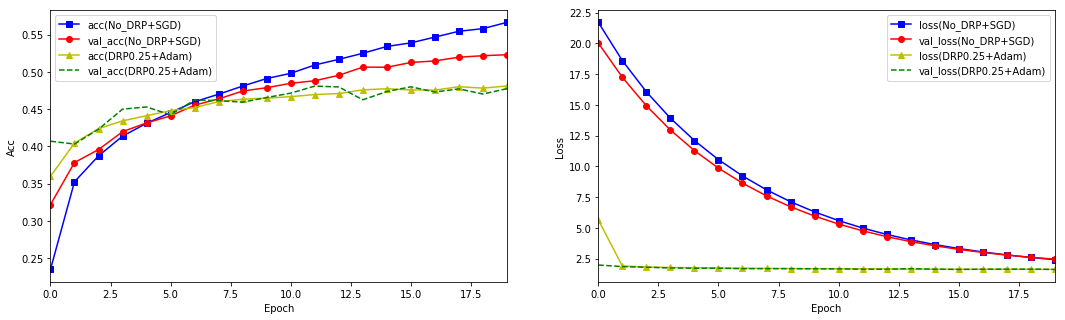

In [16]:
"""
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results = show_train_history(results)

In [12]:
df_acc_results

,acc(No_DRP+SGD),val_acc(No_DRP+SGD),acc(DRP0.25+Adam),val_acc(DRP0.25+Adam)
0,0.23504,0.3219,0.35996,0.4070
1,0.35260,0.3784,0.40444,0.4032
2,0.38736,0.3958,0.42386,0.4231
3,0.41380,0.4198,0.43430,0.4500
4,0.43106,0.4316,0.44122,0.4530
5,0.44552,0.4410,0.44806,0.4424
6,0.45998,0.4554,0.45214,0.4624
7,0.47000,0.4638,0.46006,0.4614
8,0.48098,0.4743,0.46332,0.4594
9,0.49108,0.4788,0.46486,0.4656


In [13]:
df_loss_results

,loss(No_DRP+SGD),val_loss(No_DRP+SGD),loss(DRP0.25+Adam),val_loss(DRP0.25+Adam)
0,21.709878,20.028049,5.663570,1.990882
1,18.604198,17.249164,1.913868,1.862497
2,16.065042,14.929160,1.825821,1.812254
3,13.923945,12.962961,1.790554,1.752582
4,12.105528,11.292198,1.769981,1.730219
5,10.554828,9.864943,1.742727,1.735016
6,9.231557,8.647361,1.734876,1.694062
7,8.101015,7.609994,1.716036,1.696235
8,7.134858,6.724419,1.700354,1.695981
9,6.307405,5.968088,1.694552,1.684872
